In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/.conda/envs/psps2/bin/python
farshed.abdukhakimov


cn-11
/home/farshed.abdukhakimov/projects/psps2


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from torch.optim import SGD, Adam

from momo import Momo

import matplotlib.pyplot as plt

import experiments.loss_functions as lf
from experiments.utils import get_dataset

torch.set_default_dtype(torch.float64)

%load_ext line_profiler

/home/farshed.abdukhakimov/.conda/envs/psps2/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/farshed.abdukhakimov/.conda/envs/psps2/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/farshed.abdukhakimov/.conda/envs/psps2/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [4]:
import os 
from sklearn.datasets import load_svmlight_file

torch.manual_seed(0)

batch_size = 256
# dataset_name = "covtype.libsvm.binary"
dataset_name = "mushrooms"
percentage = 1.0

EPOCHS = 50
# train_dataloader, train_data, train_target = get_dataset(dataset_name, batch_size, scale_data)
datasets_path = os.getenv("LIBSVM_DIR")
trainX, trainY = load_svmlight_file(f"{datasets_path}/{dataset_name}")
sample = np.random.choice(trainX.shape[0], round(trainX.shape[0] * percentage), replace=False)

assert sample.shape == np.unique(sample).shape

trainX = trainX[sample]
trainY = trainY[sample]

train_data = torch.tensor(trainX.toarray())
train_target = torch.tensor(trainY)

train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=False)


scale = 5
r1 = -scale
r2 = scale
scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
scaling_vec = torch.pow(torch.e, scaling_vec)
train_data_scaled = scaling_vec * train_data

train_load_scaled = data_utils.TensorDataset(train_data_scaled, train_target)
train_dataloader_scaled = DataLoader(train_load_scaled, batch_size=batch_size, shuffle=True)

loss_function = lf.logreg
loss_grad = lf.grad_logreg
loss_hessian = lf.hess_logreg

if loss_function == lf.logreg:
    train_target[train_target == train_target.unique()[0]] = torch.tensor(-1.0, dtype=torch.get_default_dtype())
    train_target[train_target == train_target.unique()[1]] = torch.tensor(1.0, dtype=torch.get_default_dtype())
    assert torch.equal(train_target.unique(), torch.tensor([-1.0, 1.0]))

elif loss_function == lf.nllsq:
    train_target[train_target == train_target.unique()[0]] = 0.0
    train_target[train_target == train_target.unique()[1]] = 1.0
    assert torch.equal(train_target.unique(), torch.tensor([0.0, 1.0]))


In [5]:
train_data.shape, train_target.unique(), torch.linalg.cond(train_data)

(torch.Size([8124, 112]), tensor([-1.,  1.]), tensor(2.9019e+19))

In [6]:
# np.random.seed(0)
# n = 1000
# d = 100
# dataset_name = f"synthetic-{n}x{d}"
# modified = False
# A = np.random.randn(n,d)

# if modified:
#     U, S, VH = np.linalg.svd(A)
#     S *= 0.0
#     S = np.asarray([1/((x+1)**3) for x in range(S.shape[0])])
#     A = np.dot(U[:, :S.shape[0]] * S, VH)
#     dataset_name += "-modified"

# xopt = np.random.randn(d)
# b = A @ xopt 
# train_data = torch.Tensor(A)
# train_target = torch.Tensor(b)
# xopt = torch.Tensor(xopt)

# batch_size = 64

# train_load = data_utils.TensorDataset(train_data, train_target)
# train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=False)


# scale = 5
# r1 = -scale
# r2 = scale
# scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
# scaling_vec = torch.pow(torch.e, scaling_vec)
# train_data_scaled = scaling_vec * train_data

# train_load_scaled = torch.utils.data.TensorDataset(train_data_scaled, train_target)
# train_dataloader_scaled = torch.utils.data.DataLoader(train_load_scaled, batch_size=batch_size, shuffle=False)


# EPOCHS = 500
# loss_function = lf.mse
# loss_grad = lf.grad_mse
# loss_hessian = lf.hess_mse

In [7]:
def run_optimizer(optimizer, lr, train_data, train_target, train_dataloader):
    # parameters
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
    opt = optimizer([w], lr=lr)

    # logging 
    hist = []
    
    def compute_loss(w, data, target):
        loss = loss_function(w, data, target)
        loss.backward()
        return loss
    
    def compute_loss_graph(w, data, target):
        loss = loss_function(w, data, target)
        loss.backward(create_graph=True)
        return loss


    for epoch in range(EPOCHS):

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]
        print(f"[{epoch}/{EPOCHS}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()} | Acc: {acc}")
        hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), acc])

        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)
            opt.zero_grad()
            if isinstance(opt, Momo):
                closure = lambda: compute_loss(w, batch_data, batch_target)
                opt.step(closure=closure)
            elif isinstance(opt, SP2Plus):
                closure = lambda: compute_loss_graph(w, batch_data, batch_target)
                opt.step(closure=closure)
            else:
                loss = compute_loss(w, batch_data, batch_target)
                opt.step()

    return hist

# SP2 for GLM

In [8]:
def run_sp2_glm(train_data, train_target, train_dataloader, epochs):

    # parameters
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    # save loss and grad size to history
    hist = []

    # define loss function
    loss_function = lf.logreg

    def logreg_a(w, X, y):
        r = torch.exp(-y * (X @ w))
        return (r/(1 + r)) * -y

    def logreg_h(w, X, y):
        r = torch.exp(-y * (X @ w))
        return (r/torch.square(1 + r)) 


    loss = loss_function(w, train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    f_grad = g.clone().detach() 
    

    for epoch in range(epochs):

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        grad_norm_sq = torch.linalg.norm(g) ** 2  
        acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]

        print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
        hist.append([loss.item(), grad_norm_sq.item(), acc])
            
        for i, (batch_data, batch_target) in enumerate(train_dataloader):  

            loss = loss_function(w, batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.clone().detach()

            a = logreg_a(w, batch_data, batch_target)
            h = logreg_h(w, batch_data, batch_target)

            det = a*a - 2 * h * loss
            if det >= 0:
                step_size = (1 - (torch.sqrt(det) / torch.abs(a))).item()
            else:
                step_size = 1.0

            with torch.no_grad():
                w.sub_((a/h)*(batch_data.flatten()/torch.norm(batch_data)**2), alpha=step_size)


    return hist


In [ ]:
hist_sp2glm = run_sp2_glm(train_data, train_target, train_dataloader, 50)

# SP2+

In [9]:
def run_sp2(train_data, train_target, train_dataloader, epochs, lr=1.0):

    w_tp1 = torch.zeros(train_data.shape[1], device=device).requires_grad_()
    w_t = w_tp1 * 1.0

    # logging 
    hist = []

    for epoch in range(epochs):

        loss = loss_function(w_tp1, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w_tp1, create_graph=True)
        acc = (np.sign(train_data @ w_tp1.detach().numpy()) == train_target).sum() / train_target.shape[0]
        print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()} | Acc: {acc}")
        hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), acc])

        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            closure  = lambda w: loss_function(w, batch_data, batch_target)
            wdiff = torch.sub(w_t, w_tp1)
            hessvgrad = torch.autograd.functional.hvp(closure, w_tp1, wdiff, create_graph=True)[1]
            with torch.no_grad():
                q = loss + torch.dot(g, wdiff) + 0.5 * torch.dot(wdiff, hessvgrad)
                nablaq = torch.add(g, hessvgrad)
                nablaqnorm = torch.norm(nablaq)
                if nablaqnorm < 1e-22:
                    break
                w_t = w_tp1 * 1.0
                w_tp1.sub_(nablaq, alpha = lr*q/nablaqnorm**2)

    return hist

def run_sp2plus(train_data, train_target, train_dataloader, epochs, lr=1.0):

    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
    # save loss and grad size to history
    hist = []
       
    for epoch in range(epochs):

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        grad_norm_sq = torch.linalg.norm(g) ** 2  
        acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]

        print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
        hist.append([loss.item(), grad_norm_sq.item(), acc])
            

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            loss = loss_function(w, batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.clone().detach()

            loss_closure = lambda w: loss_function(w, batch_data, batch_target)
            hgp = torch.autograd.functional.hvp(loss_closure, w, g, create_graph=True)[1]

            with torch.no_grad():
                gnormsq = torch.norm(f_grad)**2
                sps_step = loss.item() / gnormsq
                w.sub_(sps_step * f_grad, alpha=lr)
                gdiffHgp = torch.sub(f_grad, hgp, alpha=sps_step)
                if torch.norm(gdiffHgp)**2 > 1e-10:
                        w.sub_(0.5 * (sps_step**2) * gdiffHgp * torch.dot(f_grad, gdiffHgp)/ (torch.norm(gdiffHgp)**2))
            

    return hist


In [10]:
def hvp_from_grad(grads_tuple, list_params, vec_tuple):
    # don't damage grads_tuple. Grads_tuple should be calculated with create_graph=True
    dot = 0.
    for grad, vec in zip(grads_tuple, vec_tuple):
        dot += grad.mul(vec).sum()
    return torch.autograd.grad(dot, list_params, retain_graph=True)[0]


def custom_sp2plus(train_data, train_target, train_dataloader, epochs, lr=1.0):

    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
    # save loss and grad size to history
    hist = []

    eps = 1e-8
       
    for epoch in range(epochs):

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        grad_norm_sq = torch.linalg.norm(g) ** 2  
        acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]

        print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
        hist.append([loss.item(), grad_norm_sq.item(), acc])
            

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            loss = loss_function(w, batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.clone().detach()

            loss_closure = lambda w: loss_function(w, batch_data, batch_target)
            # hgp = torch.autograd.functional.hvp(loss_closure, w, g, create_graph=True)[1]
            hgp = torch.autograd.grad(g, w, grad_outputs=g, retain_graph=True)[0]

            # hgp = hvp_from_grad(list(g), w, list(g))
            # print(torch.norm(hgp - hgp2))
            
            grad_norm_sq = torch.dot(f_grad, f_grad)
            polyak = loss / (grad_norm_sq + eps)
            v = f_grad - (hgp * polyak)
            v_norm_sq = torch.dot(v, v)
            step = (polyak * f_grad) + (0.5 * polyak**2 * (torch.dot(hgp, f_grad) / (v_norm_sq + eps )) * v) 

            with torch.no_grad():
                w.sub_(step, alpha=lr)

    return hist

In [11]:
class SP2Plus(torch.optim.Optimizer):

    def __init__(
            self, 
            params,
            lr=1.0,
            eps=1e-8):
        
        defaults = dict(lr=lr, eps=eps)

        super().__init__(params, defaults)
        
    def step(self, closure=None):
        
        loss = None 
        if closure is not None:
            with torch.enable_grad():
                loss = closure()


        # loss_closure = lambda w: loss_function(w, batch_data, batch_target)
        # hgp = torch.autograd.functional.hvp(loss_closure, w, g, create_graph=True)[1]

        for group in self.param_groups:
            for p in group["params"]:
                grad_flat = torch.flatten(p.grad)
                p_flat = torch.flatten(p)
                eps = group["eps"]
                lr =group["lr"]
                hgp = torch.autograd.grad(grad_flat, p_flat, grad_outputs=grad_flat, retain_graph=True)[0]
                # hgp = torch.autograd.functional.hvp(closure, p, p.grad)[1]
                # hgp = hvp_from_grad(list(p.grad), p, list(p.grad))
                
                grad_norm_sq = torch.dot(grad_flat, grad_flat)
                polyak = loss / (grad_norm_sq + eps)
                v = grad_flat - (hgp * polyak)
                v_norm_sq = torch.dot(v, v)
                step = (polyak * grad_flat) + (0.5 * polyak**2 * (torch.dot(hgp, grad_flat) / (v_norm_sq + eps )) * v) 
                with torch.no_grad():
                    p.sub_(step, alpha=lr)


        return loss

In [102]:
hist_optim_sp2plus = run_optimizer(SP2Plus, 1.0, train_data, train_target, train_dataloader)

[0/50] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Acc: 0.0
[1/50] | Loss: 0.14714199231261044 | GradNorm^2: 0.11712411077569033 | Acc: 0.9304529788281635
[2/50] | Loss: 0.00476890391074857 | GradNorm^2: 7.031096881645872e-05 | Acc: 0.9993845396356474
[3/50] | Loss: 0.0016793443746531335 | GradNorm^2: 8.543149581790745e-06 | Acc: 0.999507631708518
[4/50] | Loss: 0.01426772694831612 | GradNorm^2: 0.0012475056362657706 | Acc: 0.9935992122107337
[5/50] | Loss: 0.00024875182003345283 | GradNorm^2: 5.777317182629705e-08 | Acc: 1.0
[6/50] | Loss: 7.382765862521514e-05 | GradNorm^2: 1.3109390188720882e-08 | Acc: 1.0
[7/50] | Loss: 3.4235409321344465e-05 | GradNorm^2: 2.5366178411135053e-10 | Acc: 1.0
[8/50] | Loss: 2.683287614547735e-05 | GradNorm^2: 1.2075459054650018e-10 | Acc: 1.0
[9/50] | Loss: 2.2772238224234472e-05 | GradNorm^2: 7.523995715484701e-11 | Acc: 1.0
[10/50] | Loss: 2.013444690896867e-05 | GradNorm^2: 4.633994326287922e-11 | Acc: 1.0
[11/50] | Loss: 1.82745

In [103]:
hist_custom_sp2plus = custom_sp2plus(train_data, train_target, train_dataloader, EPOCHS)

[0/50] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/50] | Loss: 0.14714199231261044 | GradNorm^2: 0.11712411077569033 | Accuracy: 0.9304529788281635
[2/50] | Loss: 0.00476890391074857 | GradNorm^2: 7.031096881645872e-05 | Accuracy: 0.9993845396356474
[3/50] | Loss: 0.0016793443746531335 | GradNorm^2: 8.543149581790745e-06 | Accuracy: 0.999507631708518
[4/50] | Loss: 0.01426772694831612 | GradNorm^2: 0.0012475056362657706 | Accuracy: 0.9935992122107337
[5/50] | Loss: 0.00024875182003345283 | GradNorm^2: 5.777317182629705e-08 | Accuracy: 1.0
[6/50] | Loss: 7.382765862521514e-05 | GradNorm^2: 1.3109390188720882e-08 | Accuracy: 1.0


[7/50] | Loss: 3.4235409321344465e-05 | GradNorm^2: 2.5366178411135053e-10 | Accuracy: 1.0
[8/50] | Loss: 2.683287614547735e-05 | GradNorm^2: 1.2075459054650018e-10 | Accuracy: 1.0
[9/50] | Loss: 2.2772238224234472e-05 | GradNorm^2: 7.523995715484701e-11 | Accuracy: 1.0
[10/50] | Loss: 2.013444690896867e-05 | GradNorm^2: 4.633994326287922e-11 | Accuracy: 1.0
[11/50] | Loss: 1.827456843192992e-05 | GradNorm^2: 2.978661237835809e-11 | Accuracy: 1.0
[12/50] | Loss: 1.6876110609826168e-05 | GradNorm^2: 2.204214751439006e-11 | Accuracy: 1.0
[13/50] | Loss: 1.5772498710762815e-05 | GradNorm^2: 1.8969179020632028e-11 | Accuracy: 1.0
[14/50] | Loss: 1.486980183469889e-05 | GradNorm^2: 1.7790595146631808e-11 | Accuracy: 1.0
[15/50] | Loss: 1.4111393190208507e-05 | GradNorm^2: 1.716682894229719e-11 | Accuracy: 1.0
[16/50] | Loss: 1.3461120267322033e-05 | GradNorm^2: 1.658613397995027e-11 | Accuracy: 1.0
[17/50] | Loss: 1.289470607949363e-05 | GradNorm^2: 1.590901653562319e-11 | Accuracy: 1.0
[18

In [104]:
hist_custom_sp2plus_scaled = custom_sp2plus(train_data_scaled, train_target, train_dataloader_scaled, EPOCHS)

[0/50] | Loss: 0.6931471805599453 | GradNorm^2: 94.77107648838604 | Accuracy: 0.0


[1/50] | Loss: 1.27511113523195 | GradNorm^2: 503.0331163596341 | Accuracy: 0.533481043820778
[2/50] | Loss: 0.24683573139463508 | GradNorm^2: 77.32415001539106 | Accuracy: 0.879615952732644
[3/50] | Loss: 0.2565114265254974 | GradNorm^2: 114.32736335700359 | Accuracy: 0.8867552929591335
[4/50] | Loss: 0.15813012587443076 | GradNorm^2: 17.986673472262563 | Accuracy: 0.9474396848842934
[5/50] | Loss: 0.20334021544336547 | GradNorm^2: 53.21718285772055 | Accuracy: 0.9153126538650911
[6/50] | Loss: 0.14569903672686155 | GradNorm^2: 13.765682850778745 | Accuracy: 0.9435007385524372
[7/50] | Loss: 0.1673787273176385 | GradNorm^2: 12.276024945378976 | Accuracy: 0.9321762678483506
[8/50] | Loss: 0.1886596786018115 | GradNorm^2: 47.02965457568717 | Accuracy: 0.8964795667159035
[9/50] | Loss: 0.12121463850530899 | GradNorm^2: 2.037122478932933 | Accuracy: 0.9487936976858691
[10/50] | Loss: 0.30415111232915265 | GradNorm^2: 30.23705492710654 | Accuracy: 0.8897095027080256
[11/50] | Loss: 0.22794

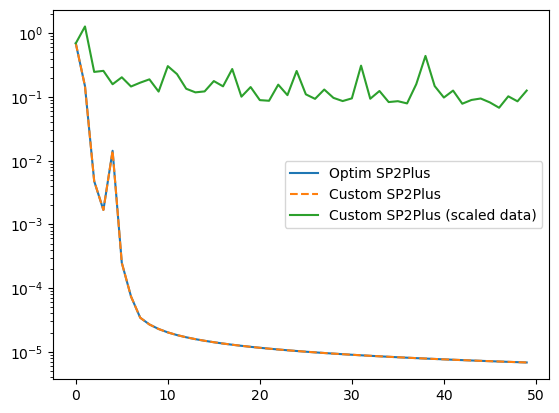

In [105]:
plt.semilogy([x[0] for x in hist_optim_sp2plus], label="Optim SP2Plus")
plt.semilogy([x[0] for x in hist_custom_sp2plus], linestyle="--", label="Custom SP2Plus")
plt.semilogy([x[0] for x in hist_custom_sp2plus_scaled], label="Custom SP2Plus (scaled data)")

plt.legend()


# PSPS2 Rank 1 Scaling
$
w^* = \arg\min_{w\in\mathbb{R} ^d}\frac{1}{2} \|w - w_t\|_{B_t} \nonumber \\
      \text{s.t.} \quad f_i(w_t) +  \langle  \nabla  f_i(w_t), w-w_t\rangle +\frac{1}{2}\langle B_t(w-w^t), w - w^t \rangle \leq 0 \\ 
      B_t = \frac{yy^T}{s^Ty} \\ 
      B_t^{+} = \frac{ss^T}{s^Ty} \\ 
      \text{where} \quad s = \Big ( \nabla^2  f_i(w_t) \Big ) ^{-1} \nabla f_i(w_t) \\ 
      y = \nabla^2 f_i(w_t) s = \nabla f_i(w_t) \\ 
      \text{Update Rule: } \\
      w_{t+1} = w_t - \frac{\alpha}{1 + \alpha} B_t^{+} \nabla f_i(w_t)
$

In [542]:
def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)

def run_psps2(train_data, train_target, train_dataloader, epochs, precond_method="cg", **kwargs):

    torch.manual_seed(0)
    
    # parameters
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    # save loss and grad size to history
    hist = []
    

    loss = loss_function(w, train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    f_grad = g.clone().detach() 


    if precond_method == "none":
        D = torch.ones_like(w)
    elif precond_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk = diag_estimate_old(w, g, init_iters)
    elif precond_method == "cg" or precond_method == "pcg":
        s = torch.zeros_like(w) # s = H_inv * grad
        r = f_grad - torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
        p = r.detach().clone()
        r_prev = torch.dot(r, r)
        MAX_ITER = train_data.shape[1] * 2
        # MAX_ITER = 1000

    elif precond_method == "scaling_vec":
        scaling_vec = kwargs["scaling_vec"]
        D = (1 / scaling_vec)**2
    elif precond_method == "adam" or precond_method == "adam_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)
        step_t = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif precond_method == "adagrad" or precond_method == "adagrad_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)

    pcg_method = kwargs.get("pcg_method")
    if pcg_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk_pcg = diag_estimate_old(w, g, init_iters)
    elif pcg_method == "adam":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
        step_t_pcg = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif pcg_method == "adagrad":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
    elif pcg_method == None:
        D_pcg = torch.ones_like(g)

    cg_steps = []

    for epoch in range(epochs):

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        grad_norm_sq = torch.linalg.norm(g) ** 2  
        acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]

        print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
        hist.append([loss.item(), grad_norm_sq.item(), acc])
           
        for i, (batch_data, batch_target) in enumerate(train_dataloader):  

            loss = loss_function(w, batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.detach().clone()

            if precond_method == "hess_diag":
                hess = loss_hessian(w, batch_data, batch_target)
                hess_diag_inv = 1 / torch.diag(hess)
                s = hess_diag_inv * f_grad

            elif precond_method == "scaling_vec":
                s = D * f_grad

            elif precond_method == "adam" or precond_method == "adam_m":
                step_t += 1
                v = betas[1] * v + (1 - betas[1]) * g.square()
                v_hat = v / (1 - torch.pow(betas[1], step_t))

                if precond_method == "adam":
                    D = 1 / (torch.sqrt(v_hat) + 1e-6)
                elif precond_method == "adam_m":
                    D = 1 / (v_hat + 1e-6) 
                s = D * f_grad

            elif precond_method == "adagrad" or precond_method == "adagrad_m":
                v.add_(torch.square(g))
                if precond_method == "adagrad":
                    D = 1 / (torch.sqrt(v) + 1e-6)
                elif precond_method == "adagrad_m":
                    D = 1 / (v + 1e-6)
                s = D * f_grad

            elif precond_method == "none":
                s = D * f_grad

            elif precond_method == "hutch":
                vk = diag_estimate_old(w, g, 1)

                # Smoothing and Truncation 
                Dk = beta * Dk + (1 - beta) * vk
                Dk_hat = torch.abs(Dk)
                Dk_hat[Dk_hat < alpha] = alpha

                D = 1 / Dk_hat
                s = D * f_grad

            elif precond_method == "cg":

                hess = loss_hessian(w, batch_data, batch_target)
                hess_inv = 1 / torch.diag(hess)
                
                # CG is here
                s = torch.zeros_like(w) # s = H_inv * grad
                r = f_grad.clone()
                p = r.clone()

                for cg_step in range(MAX_ITER):
                    hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                    alpha_k = torch.dot(r, r) / torch.dot(p, hvp)
                    s = s + alpha_k * p
                    r_prev = r.clone()
                    r = r - alpha_k * hvp
                    if torch.norm(r) < 1e-4:
                        Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]    
                        diff = torch.norm(Ax - f_grad)
                        # print(f"CG Took {cg_step} to reach diff={diff}")
                        cg_steps.append(cg_step)
                        break

                    beta_k = torch.dot(r, r) / torch.dot(r_prev, r_prev)
                    p = r + beta_k * p


            elif precond_method == "pcg":

                if pcg_method == "hutch":
                    vk_pcg = diag_estimate_old(w, g, 1)
                    # Smoothing and Truncation 
                    Dk_pcg = beta * Dk_pcg + (1 - beta) * vk_pcg
                    Dk_hat = torch.abs(Dk_pcg)
                    Dk_hat[Dk_hat < alpha] = alpha
                    D_pcg = 1 / Dk_hat
                elif pcg_method == "adam":
                    step_t_pcg += 1
                    v_pcg = betas[1] * v_pcg + (1 - betas[1]) * f_grad.square()
                    v_hat = v_pcg / (1 - torch.pow(betas[1], step_t_pcg))
                    D_pcg = 1 / (torch.sqrt(v_hat) + 1e-6)
                elif pcg_method == "adagrad":
                    v_pcg.add_(f_grad.square())
                    D_pcg = 1 / (torch.sqrt(v_pcg) + 1e-6)

                # hess = loss_hessian(w, batch_data, batch_target)
                # hess_diag_inv = 1 / torch.diag(hess)

                hess_diag_inv = D_pcg.clone()
                # Preconditioned CG is here
                s = torch.zeros_like(w) # s = H_inv * grad
                r = f_grad.clone()
                z = hess_diag_inv * r
                p = z.detach().clone()

                for cg_step in range(MAX_ITER):
                    hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                    alpha_k = torch.dot(r, z) / torch.dot(p, hvp)
                    s = s + alpha_k * p
                    r_prev = r.clone()
                    r = r - alpha_k * hvp
                    if torch.norm(r) < 1e-6:
                        Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]    
                        diff = torch.norm(Ax - f_grad)
                        # print(f"PCG Took {cg_step} to reach diff={diff}")
                        cg_steps.append(cg_step)
                        break
                    
                    z_prev = z.clone()
                    z = hess_diag_inv * r
                    beta_k = torch.dot(r, z) / torch.dot(r_prev, z_prev)
                    p = z + beta_k * p    


            grad_norm_sq_scaled = torch.dot(f_grad, s)

            if 2 * loss <= grad_norm_sq_scaled:
                c = loss / ( grad_norm_sq_scaled )
                det = 1 - 2 * c
                if det < 0.0:
                    step_size = 1.0
                else:
                    step_size = 1 - torch.sqrt(det)
            else:
                # print(f"[{epoch}, {i}] No solution")
                step_size = 1.0

                
            with torch.no_grad():
                w.sub_(step_size * s)

    return hist, cg_steps

In [551]:
hist_psps2_cg, cg_steps = run_psps2(train_data, train_target, train_dataloader, epochs=EPOCHS, precond_method="cg")

[0/500] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0


[1/500] | Loss: 0.0002138993027631528 | GradNorm^2: 1.8600525937482155e-07 | Accuracy: 1.0
[2/500] | Loss: 6.320564265464782e-05 | GradNorm^2: 6.3436589603767004e-09 | Accuracy: 1.0
[3/500] | Loss: 4.306363999751554e-05 | GradNorm^2: 6.604098234470998e-09 | Accuracy: 1.0
[4/500] | Loss: 2.50028641420224e-05 | GradNorm^2: 1.8205935558745458e-09 | Accuracy: 1.0
[5/500] | Loss: 1.6597276833839527e-05 | GradNorm^2: 9.060821120339324e-10 | Accuracy: 1.0
[6/500] | Loss: 1.5647055938479422e-05 | GradNorm^2: 1.5698092015959198e-09 | Accuracy: 1.0
[7/500] | Loss: 1.0818369783700588e-05 | GradNorm^2: 9.905119104253222e-10 | Accuracy: 1.0
[8/500] | Loss: 6.824282966865842e-06 | GradNorm^2: 3.5549212637225747e-10 | Accuracy: 1.0
[9/500] | Loss: 1.2455676125947048e-05 | GradNorm^2: 2.5401261696408114e-09 | Accuracy: 1.0
[10/500] | Loss: 7.361037742401707e-06 | GradNorm^2: 7.993921258604996e-10 | Accuracy: 1.0
[11/500] | Loss: 7.45205633574454e-06 | GradNorm^2: 9.103959215784969e-10 | Accuracy: 1.0


In [552]:
hist_psps2_pcg_adam, pcg_steps_adam = run_psps2(train_data, train_target, train_dataloader, epochs=EPOCHS, precond_method="pcg", pcg_method="adam")

[0/500] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0


[1/500] | Loss: 0.0010183530520705075 | GradNorm^2: 2.9204339677480234e-06 | Accuracy: 0.9996307237813885
[2/500] | Loss: 0.00011752260012338645 | GradNorm^2: 1.925797055939217e-07 | Accuracy: 1.0
[3/500] | Loss: 0.00010216733358476865 | GradNorm^2: 1.553735415705214e-07 | Accuracy: 1.0
[4/500] | Loss: 0.00013347056815202462 | GradNorm^2: 2.455009466825691e-07 | Accuracy: 1.0
[5/500] | Loss: 0.0001920607065747875 | GradNorm^2: 4.3960258914042733e-07 | Accuracy: 1.0
[6/500] | Loss: 0.00021435104449828594 | GradNorm^2: 5.182886014584245e-07 | Accuracy: 0.9998769079271295
[7/500] | Loss: 0.00022468403874174674 | GradNorm^2: 5.565612729453127e-07 | Accuracy: 0.9998769079271295
[8/500] | Loss: 0.00024138888898153323 | GradNorm^2: 6.128567881797091e-07 | Accuracy: 0.9998769079271295
[9/500] | Loss: 0.00023048977511459594 | GradNorm^2: 5.709259110369057e-07 | Accuracy: 0.9998769079271295
[10/500] | Loss: 0.00022062722047378573 | GradNorm^2: 5.327791712336003e-07 | Accuracy: 0.9998769079271295

In [553]:
hist_psps2_pcg_adagrad, pcg_steps_adagrad = run_psps2(train_data, train_target, train_dataloader, epochs=EPOCHS, precond_method="pcg", pcg_method="adagrad")

[0/500] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/500] | Loss: 0.0007801898716312739 | GradNorm^2: 2.297091877218975e-06 | Accuracy: 0.9996307237813885
[2/500] | Loss: 0.00014322533292312963 | GradNorm^2: 2.6771093902556676e-07 | Accuracy: 1.0
[3/500] | Loss: 9.251389341604492e-05 | GradNorm^2: 1.309526632173173e-07 | Accuracy: 1.0
[4/500] | Loss: 0.00011369837457193611 | GradNorm^2: 1.8786654683649823e-07 | Accuracy: 1.0
[5/500] | Loss: 0.0001830928142010021 | GradNorm^2: 4.0860398475172003e-07 | Accuracy: 1.0
[6/500] | Loss: 0.00020320403734509814 | GradNorm^2: 4.795585159256671e-07 | Accuracy: 0.9998769079271295
[7/500] | Loss: 0.00025742861466417565 | GradNorm^2: 6.749440894145582e-07 | Accuracy: 0.9997538158542589
[8/500] | Loss: 0.00023762533286528738 | GradNorm^2: 5.996690963569111e-07 | Accuracy: 0.9998769079271295
[9/500] | Loss: 0.00022626442871963878 | GradNorm^2: 5.55885281380918e-07 | Accuracy: 0.9998769079271295
[10/500] | Loss: 0.000

In [554]:
hist_psps2_pcg_hutch, pcg_steps_hutch = run_psps2(train_data, train_target, train_dataloader, epochs=EPOCHS, precond_method="pcg", pcg_method="hutch", hutch_init_iters=10000)

[0/500] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/500] | Loss: 0.0002406427928127222 | GradNorm^2: 6.580944738270614e-07 | Accuracy: 0.9998769079271295
[2/500] | Loss: 5.6751148311334716e-05 | GradNorm^2: 5.5448169251183345e-08 | Accuracy: 1.0
[3/500] | Loss: 1.8854572286576238e-05 | GradNorm^2: 6.586907096867788e-09 | Accuracy: 1.0
[4/500] | Loss: 1.0172854060948027e-05 | GradNorm^2: 1.9726679686562445e-09 | Accuracy: 1.0
[5/500] | Loss: 1.4253938447743322e-05 | GradNorm^2: 3.9174616558475e-09 | Accuracy: 1.0
[6/500] | Loss: 1.225137491608042e-05 | GradNorm^2: 2.9182251444791942e-09 | Accuracy: 1.0
[7/500] | Loss: 1.0049887030520463e-05 | GradNorm^2: 1.9786874383133325e-09 | Accuracy: 1.0
[8/500] | Loss: 8.113307139358094e-06 | GradNorm^2: 1.2978958601770582e-09 | Accuracy: 1.0
[9/500] | Loss: 6.404035294558372e-06 | GradNorm^2: 8.130819719343019e-10 | Accuracy: 1.0
[10/500] | Loss: 4.952149025699327e-06 | GradNorm^2: 4.884326307016682e-10 | Accur

In [555]:
hist_psps2_adam, _ = run_psps2(train_data, train_target, train_dataloader, epochs=EPOCHS, precond_method="adam")

[0/500] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/500] | Loss: 0.006738728701389641 | GradNorm^2: 2.01161788818448e-05 | Accuracy: 0.9996307237813885
[2/500] | Loss: 0.002229267059727484 | GradNorm^2: 2.579354233537991e-06 | Accuracy: 0.9996307237813885
[3/500] | Loss: 0.0012180720270249972 | GradNorm^2: 1.2302161826641547e-06 | Accuracy: 1.0
[4/500] | Loss: 0.0007944878862478577 | GradNorm^2: 5.273108392398081e-07 | Accuracy: 1.0
[5/500] | Loss: 0.0005684304532977631 | GradNorm^2: 2.2984273680528724e-07 | Accuracy: 1.0
[6/500] | Loss: 0.0004318183787939104 | GradNorm^2: 1.0623015988252191e-07 | Accuracy: 1.0
[7/500] | Loss: 0.00034222287253409184 | GradNorm^2: 5.26664159515609e-08 | Accuracy: 1.0
[8/500] | Loss: 0.0002798299812163157 | GradNorm^2: 2.8035585299686153e-08 | Accuracy: 1.0
[9/500] | Loss: 0.00023433794678368185 | GradNorm^2: 1.5984947753549928e-08 | Accuracy: 1.0
[10/500] | Loss: 0.00019994997586530043 | GradNorm^2: 9.724794910209828e

In [556]:
hist_psps2_adagrad, _ = run_psps2(train_data, train_target, train_dataloader, epochs=EPOCHS, precond_method="adagrad")

[0/500] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/500] | Loss: 0.019424414635155124 | GradNorm^2: 6.699627506550478e-05 | Accuracy: 0.9992614475627769
[2/500] | Loss: 0.010597525807285513 | GradNorm^2: 2.67953928217987e-05 | Accuracy: 0.9996307237813885
[3/500] | Loss: 0.007407169220460007 | GradNorm^2: 1.2527880529254715e-05 | Accuracy: 0.9996307237813885
[4/500] | Loss: 0.0057259177485792945 | GradNorm^2: 6.77084075049282e-06 | Accuracy: 0.9996307237813885
[5/500] | Loss: 0.004677650433332011 | GradNorm^2: 4.09379433159253e-06 | Accuracy: 0.9996307237813885
[6/500] | Loss: 0.003958198949311862 | GradNorm^2: 2.6978171064028906e-06 | Accuracy: 0.9996307237813885
[7/500] | Loss: 0.0034327910186500873 | GradNorm^2: 1.9026859471043532e-06 | Accuracy: 0.9996307237813885
[8/500] | Loss: 0.0030319255792333358 | GradNorm^2: 1.4158602365690296e-06 | Accuracy: 0.9997538158542589
[9/500] | Loss: 0.0027158871405746437 | GradNorm^2: 1.0988785855070878e-06 | Ac

In [557]:
hist_psps2_hutch, _ = run_psps2(train_data, train_target, train_dataloader, epochs=EPOCHS, precond_method="hutch", hutch_init_iters=10000)

[0/500] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/500] | Loss: 0.03358523091943 | GradNorm^2: 0.00010897455742059738 | Accuracy: 0.9940915805022157
[2/500] | Loss: 0.0180657977376317 | GradNorm^2: 5.672078184020427e-05 | Accuracy: 0.9983998030526834
[3/500] | Loss: 0.012528908403367654 | GradNorm^2: 3.963799090729157e-05 | Accuracy: 0.999015263417036
[4/500] | Loss: 0.009555228211265995 | GradNorm^2: 2.3139454114679423e-05 | Accuracy: 0.999015263417036
[5/500] | Loss: 0.0077016092373151665 | GradNorm^2: 1.3815086457534622e-05 | Accuracy: 0.9991383554899065
[6/500] | Loss: 0.006445179779148645 | GradNorm^2: 8.791512394123832e-06 | Accuracy: 0.9993845396356474
[7/500] | Loss: 0.005540585649440614 | GradNorm^2: 5.958582131242891e-06 | Accuracy: 0.9997538158542589
[8/500] | Loss: 0.004858990733264132 | GradNorm^2: 4.254593346420403e-06 | Accuracy: 0.9997538158542589
[9/500] | Loss: 0.004327255551513818 | GradNorm^2: 3.168671569342888e-06 | Accuracy: 0.

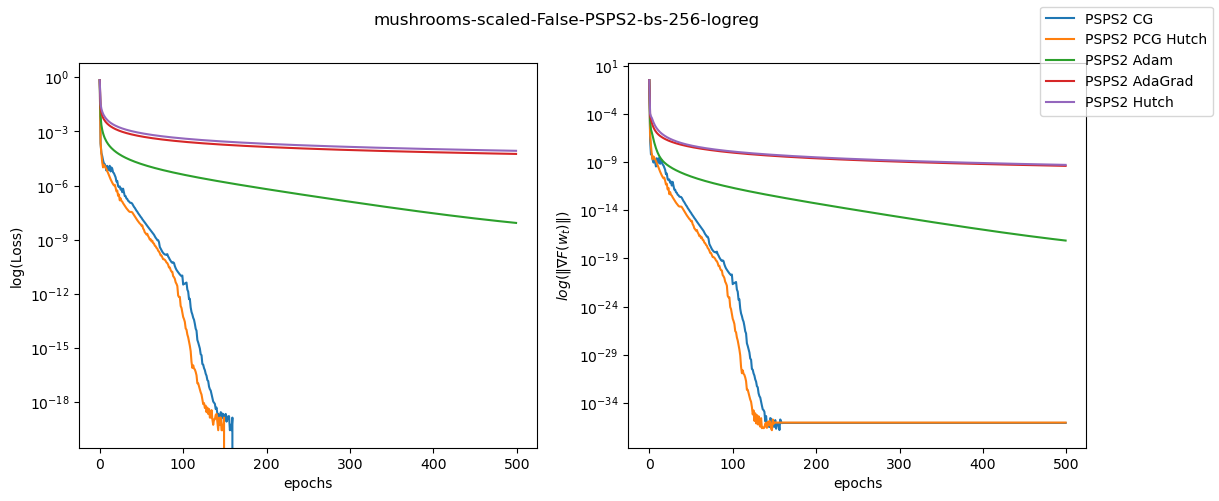

In [560]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].semilogy([x[0] for x in hist_psps2_cg], label=f"PSPS2 CG")
ax[0].semilogy([x[0] for x in hist_psps2_pcg_hutch], label=f"PSPS2 PCG Hutch")
ax[0].semilogy([x[0] for x in hist_psps2_adam], label=f"PSPS2 Adam")
ax[0].semilogy([x[0] for x in hist_psps2_adagrad], label=f"PSPS2 AdaGrad")
ax[0].semilogy([x[0] for x in hist_psps2_hutch], label=f"PSPS2 Hutch")

ax[1].semilogy([x[1] for x in hist_psps2_cg])
ax[1].semilogy([x[1] for x in hist_psps2_pcg_hutch])
ax[1].semilogy([x[1] for x in hist_psps2_adam])
ax[1].semilogy([x[1] for x in hist_psps2_adagrad])
ax[1].semilogy([x[1] for x in hist_psps2_hutch])



ax[0].set_ylabel("log(Loss)")
ax[0].set_xlabel("epochs")

ax[1].set_ylabel(r"$log(\| \nabla F(w_t) \|)$")
ax[1].set_xlabel("epochs")


fig.legend()


title = f"{dataset_name}-scaled-False-PSPS2-bs-{batch_size}-{loss_function.__name__}"
fig.suptitle(title)

plt.savefig(f"experiments/plots/{title}.jpeg", format="jpeg", dpi=200)

In [427]:
hist_psps2_none = run_psps2(train_data, train_target, train_dataloader, epochs=EPOCHS, precond_method="none")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/100] | Loss: 0.10658194671969615 | GradNorm^2: 0.0015004936689309567 | Accuracy: 0.9790743476120138
[2/100] | Loss: 0.07745718545123703 | GradNorm^2: 0.0007236573896566717 | Accuracy: 0.98301329394387
[3/100] | Loss: 0.06301790553763482 | GradNorm^2: 0.0005262424521816228 | Accuracy: 0.9838749384539636
[4/100] | Loss: 0.05363180569918059 | GradNorm^2: 0.00041320587810431505 | Accuracy: 0.9846134908911867
[5/100] | Loss: 0.0468880659096317 | GradNorm^2: 0.00033142697567671727 | Accuracy: 0.9867060561299852
[6/100] | Loss: 0.04176367314285526 | GradNorm^2: 0.0002692375788104821 | Accuracy: 0.9891678975873953
[7/100] | Loss: 0.037715877893397406 | GradNorm^2: 0.0002212072397542349 | Accuracy: 0.991752831117676
[8/100] | Loss: 0.03442422913935473 | GradNorm^2: 0.00018368002970007 | Accuracy: 0.9937223042836041
[9/100] | Loss: 0.03168649903603246 | GradNorm^2: 0.00015401874325209747 | Accuracy: 0.9951994

In [428]:
hist_psps2_none_scaled = run_psps2(train_data_scaled, train_target, train_dataloader_scaled, epochs=EPOCHS, precond_method="none")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 94.77107648838604 | Accuracy: 0.0
[1/100] | Loss: 0.49179941855035775 | GradNorm^2: 275.2743664975233 | Accuracy: 0.6957163958641064


[2/100] | Loss: 0.541555014704702 | GradNorm^2: 57.05787240011899 | Accuracy: 0.8476120137863121
[3/100] | Loss: 0.17067177473400752 | GradNorm^2: 3.2022479542622437 | Accuracy: 0.9336533727227967
[4/100] | Loss: 0.33248102793117457 | GradNorm^2: 66.8038030061249 | Accuracy: 0.8554899064500247
[5/100] | Loss: 0.17843611540553145 | GradNorm^2: 13.7065048770594 | Accuracy: 0.9433776464795667
[6/100] | Loss: 0.27227803022811625 | GradNorm^2: 38.34525664525587 | Accuracy: 0.8914327917282127
[7/100] | Loss: 2.395991602263809 | GradNorm^2: 586.367321201286 | Accuracy: 0.7386755292959133
[8/100] | Loss: 0.3555666179677164 | GradNorm^2: 58.415264524039095 | Accuracy: 0.8716149679960611
[9/100] | Loss: 0.2192606764456831 | GradNorm^2: 29.61615426190405 | Accuracy: 0.9261447562776958
[10/100] | Loss: 0.33239035966403385 | GradNorm^2: 113.4301697392159 | Accuracy: 0.8727227966518957
[11/100] | Loss: 0.14346726046986416 | GradNorm^2: 4.418785645013874 | Accuracy: 0.9569177744953224
[12/100] | Loss

In [429]:
hist_psps2_adam_m = run_psps2(train_data, train_target, train_dataloader, epochs=EPOCHS, precond_method="adam_m")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/100] | Loss: 0.006465521406293018 | GradNorm^2: 7.02557697978584e-05 | Accuracy: 0.9988921713441654
[2/100] | Loss: 0.0014149741256676892 | GradNorm^2: 1.4235556614560294e-06 | Accuracy: 0.9996307237813885
[3/100] | Loss: 0.0015735789169660569 | GradNorm^2: 3.3893385780859153e-06 | Accuracy: 0.9996307237813885
[4/100] | Loss: 0.0006172178301949576 | GradNorm^2: 1.6661544045062259e-06 | Accuracy: 0.9996307237813885
[5/100] | Loss: 0.00039230186237315635 | GradNorm^2: 1.0766617084287567e-06 | Accuracy: 0.9996307237813885
[6/100] | Loss: 0.00028676557836344044 | GradNorm^2: 7.47945255682602e-07 | Accuracy: 0.9997538158542589
[7/100] | Loss: 0.00018402747503386927 | GradNorm^2: 3.9650615122718404e-07 | Accuracy: 1.0
[8/100] | Loss: 0.00013862427082757302 | GradNorm^2: 2.527526112395375e-07 | Accuracy: 1.0
[9/100] | Loss: 7.438990704720262e-05 | GradNorm^2: 8.639782706131657e-08 | Accuracy: 1.0
[10/100] 

In [430]:
hist_psps2_adam_m_scaled = run_psps2(train_data_scaled, train_target, train_dataloader_scaled, epochs=EPOCHS, precond_method="adam_m")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 94.77107648838604 | Accuracy: 0.0
[1/100] | Loss: 0.004884002429428002 | GradNorm^2: 0.015993914829240456 | Accuracy: 0.999507631708518
[2/100] | Loss: 0.0013791188603290286 | GradNorm^2: 0.006033825800503594 | Accuracy: 0.9997538158542589


[3/100] | Loss: 0.0002939443017942235 | GradNorm^2: 0.000413703016657604 | Accuracy: 1.0
[4/100] | Loss: 9.103927058447485e-05 | GradNorm^2: 5.450672797535766e-05 | Accuracy: 1.0
[5/100] | Loss: 3.483769328047507e-05 | GradNorm^2: 6.837370837935141e-06 | Accuracy: 1.0
[6/100] | Loss: 1.0030193729661239e-05 | GradNorm^2: 1.6346684153411774e-08 | Accuracy: 1.0
[7/100] | Loss: 6.066632845401613e-06 | GradNorm^2: 1.3855283862575484e-08 | Accuracy: 1.0
[8/100] | Loss: 4.132932710340923e-06 | GradNorm^2: 3.0683129402869254e-09 | Accuracy: 1.0
[9/100] | Loss: 3.1328414849187186e-06 | GradNorm^2: 1.863211499829503e-09 | Accuracy: 1.0
[10/100] | Loss: 2.444446457696221e-06 | GradNorm^2: 6.374835926572618e-10 | Accuracy: 1.0
[11/100] | Loss: 2.0915702860541047e-06 | GradNorm^2: 2.1053751116295255e-09 | Accuracy: 1.0
[12/100] | Loss: 1.6887709317188967e-06 | GradNorm^2: 4.0860276644312833e-10 | Accuracy: 1.0
[13/100] | Loss: 1.4486449716224093e-06 | GradNorm^2: 2.863572743967877e-10 | Accuracy: 1

In [431]:
hist_psps2_adam = run_psps2(train_data, train_target, train_dataloader, epochs=EPOCHS, precond_method="adam")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/100] | Loss: 0.006391518310832827 | GradNorm^2: 0.00015583842942368449 | Accuracy: 0.9996307237813885
[2/100] | Loss: 0.0017923298642961172 | GradNorm^2: 1.5229367941275739e-06 | Accuracy: 1.0
[3/100] | Loss: 0.0009957345136304486 | GradNorm^2: 4.493811633878431e-07 | Accuracy: 1.0
[4/100] | Loss: 0.0006679801210745393 | GradNorm^2: 2.400341045020152e-07 | Accuracy: 1.0
[5/100] | Loss: 0.0004883463659646436 | GradNorm^2: 1.345021733429458e-07 | Accuracy: 1.0
[6/100] | Loss: 0.0003766251404808084 | GradNorm^2: 7.825580135275541e-08 | Accuracy: 1.0
[7/100] | Loss: 0.0003015308036439733 | GradNorm^2: 4.741430114356084e-08 | Accuracy: 1.0
[8/100] | Loss: 0.0002482160718548763 | GradNorm^2: 2.9843319617095885e-08 | Accuracy: 1.0
[9/100] | Loss: 0.00020877506587725094 | GradNorm^2: 1.9441730781861315e-08 | Accuracy: 1.0
[10/100] | Loss: 0.0001786435407800979 | GradNorm^2: 1.3064698947560501e-08 | Accuracy

In [432]:
hist_psps2_adam_scaled = run_psps2(train_data_scaled, train_target, train_dataloader_scaled, epochs=EPOCHS, precond_method="adam")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 94.77107648838604 | Accuracy: 0.0
[1/100] | Loss: 0.14207256689776507 | GradNorm^2: 6.502589631490366 | Accuracy: 0.9420236336779911
[2/100] | Loss: 0.08293157508253565 | GradNorm^2: 7.100860964778134 | Accuracy: 0.9638109305760709
[3/100] | Loss: 0.04481439473245648 | GradNorm^2: 1.2498963280622881 | Accuracy: 0.992245199409158
[4/100] | Loss: 0.22559882470971934 | GradNorm^2: 91.74382501886345 | Accuracy: 0.9316838995568686
[5/100] | Loss: 0.04057947944496238 | GradNorm^2: 2.803955234961638 | Accuracy: 0.9885524372230429
[6/100] | Loss: 0.026322003547941994 | GradNorm^2: 1.0876860113458344 | Accuracy: 0.9891678975873953
[7/100] | Loss: 0.016812412522693807 | GradNorm^2: 0.4189271325683403 | Accuracy: 0.999015263417036
[8/100] | Loss: 0.023265747167855524 | GradNorm^2: 1.1153706045059886 | Accuracy: 0.991014278680453
[9/100] | Loss: 0.017921672256802263 | GradNorm^2: 0.8757998088819321 | Accuracy: 0.9977843426883308
[10/100] | Loss: 0.0

In [433]:
hist_psps2_adagrad = run_psps2(train_data, train_target, train_dataloader, epochs=EPOCHS, precond_method="adagrad")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0


[1/100] | Loss: 0.017734393192487125 | GradNorm^2: 0.0001971845074048426 | Accuracy: 0.999015263417036
[2/100] | Loss: 0.009623272163961378 | GradNorm^2: 4.2670500161592186e-05 | Accuracy: 0.9996307237813885
[3/100] | Loss: 0.006741173283924701 | GradNorm^2: 2.0304272024157432e-05 | Accuracy: 0.9996307237813885
[4/100] | Loss: 0.005214628500295228 | GradNorm^2: 1.1753667293790654e-05 | Accuracy: 0.9996307237813885
[5/100] | Loss: 0.004256307930261406 | GradNorm^2: 7.350153516043545e-06 | Accuracy: 0.9996307237813885
[6/100] | Loss: 0.003595889477547204 | GradNorm^2: 4.824948469096814e-06 | Accuracy: 0.9996307237813885
[7/100] | Loss: 0.003112928287738292 | GradNorm^2: 3.295452858778336e-06 | Accuracy: 0.9996307237813885
[8/100] | Loss: 0.0027446037245809703 | GradNorm^2: 2.332121422816912e-06 | Accuracy: 1.0
[9/100] | Loss: 0.002454629664389084 | GradNorm^2: 1.7045976698970224e-06 | Accuracy: 1.0
[10/100] | Loss: 0.0022205195892524487 | GradNorm^2: 1.2829415205821173e-06 | Accuracy: 1.

In [434]:
hist_psps2_adagrad_scaled = run_psps2(train_data_scaled, train_target, train_dataloader_scaled, epochs=EPOCHS, precond_method="adagrad")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 94.77107648838604 | Accuracy: 0.0
[1/100] | Loss: 0.1522868591059915 | GradNorm^2: 16.260272592270887 | Accuracy: 0.941285081240768
[2/100] | Loss: 0.2367088947047066 | GradNorm^2: 69.97464924180002 | Accuracy: 0.8846627277203348
[3/100] | Loss: 0.07417109488250505 | GradNorm^2: 5.975494675419594 | Accuracy: 0.9630723781388478


[4/100] | Loss: 0.03247032693059321 | GradNorm^2: 0.2201408403271084 | Accuracy: 0.9928606597735106
[5/100] | Loss: 0.04757348594648041 | GradNorm^2: 4.998116113160422 | Accuracy: 0.9831363860167405
[6/100] | Loss: 0.032761493214989466 | GradNorm^2: 1.9323217683008131 | Accuracy: 0.9939684884293452
[7/100] | Loss: 0.017819487838166132 | GradNorm^2: 0.07138166315370895 | Accuracy: 0.9987690792712949
[8/100] | Loss: 0.016814859885050392 | GradNorm^2: 0.22813456385720668 | Accuracy: 0.9996307237813885
[9/100] | Loss: 0.012940144176523234 | GradNorm^2: 0.02540424476666948 | Accuracy: 0.9992614475627769
[10/100] | Loss: 0.011407222418720176 | GradNorm^2: 0.019481456654722912 | Accuracy: 0.9996307237813885
[11/100] | Loss: 0.010474384368585377 | GradNorm^2: 0.03942649808613061 | Accuracy: 0.9992614475627769
[12/100] | Loss: 0.010025794731269022 | GradNorm^2: 0.02982503716888553 | Accuracy: 0.999507631708518
[13/100] | Loss: 0.008323655825596162 | GradNorm^2: 0.0056444563306209256 | Accuracy:

In [435]:
hist_psps2_adagrad_m = run_psps2(train_data, train_target, train_dataloader, epochs=EPOCHS, precond_method="adagrad_m")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/100] | Loss: 0.00502609850609884 | GradNorm^2: 5.149037779463026e-05 | Accuracy: 0.9996307237813885
[2/100] | Loss: 0.0013325399643854545 | GradNorm^2: 7.619052294224149e-07 | Accuracy: 0.9997538158542589
[3/100] | Loss: 0.0007039149821082163 | GradNorm^2: 2.2022192509151142e-07 | Accuracy: 1.0


[4/100] | Loss: 0.0004957511085046899 | GradNorm^2: 1.3486274158668498e-07 | Accuracy: 1.0
[5/100] | Loss: 0.0003773596570056093 | GradNorm^2: 7.645675255799888e-08 | Accuracy: 1.0
[6/100] | Loss: 0.0003064704141286145 | GradNorm^2: 4.714852509941689e-08 | Accuracy: 1.0
[7/100] | Loss: 0.00025856978817281233 | GradNorm^2: 3.1577804531241565e-08 | Accuracy: 1.0
[8/100] | Loss: 0.0002239109378748928 | GradNorm^2: 2.2597410696318825e-08 | Accuracy: 1.0
[9/100] | Loss: 0.00019762145315995993 | GradNorm^2: 1.701311576377102e-08 | Accuracy: 1.0
[10/100] | Loss: 0.00017696928497046302 | GradNorm^2: 1.3312315747960892e-08 | Accuracy: 1.0
[11/100] | Loss: 0.00016030022677893414 | GradNorm^2: 1.0729542479482128e-08 | Accuracy: 1.0
[12/100] | Loss: 0.0001465528844084719 | GradNorm^2: 8.850675410465904e-09 | Accuracy: 1.0
[13/100] | Loss: 0.00013501424163014572 | GradNorm^2: 7.4374880052687475e-09 | Accuracy: 1.0
[14/100] | Loss: 0.00012518711010044975 | GradNorm^2: 6.34533628996885e-09 | Accuracy

In [436]:
hist_psps2_adagrad_m_scaled = run_psps2(train_data_scaled, train_target, train_dataloader_scaled, epochs=EPOCHS, precond_method="adagrad_m")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 94.77107648838604 | Accuracy: 0.0


[1/100] | Loss: 0.005039100913805373 | GradNorm^2: 0.04049008061168007 | Accuracy: 0.9998769079271295
[2/100] | Loss: 0.0011107433179610416 | GradNorm^2: 0.00042549310019199976 | Accuracy: 1.0
[3/100] | Loss: 0.0006314681736002242 | GradNorm^2: 7.975339316040051e-05 | Accuracy: 1.0
[4/100] | Loss: 0.00044328975836842365 | GradNorm^2: 1.4247347222800623e-05 | Accuracy: 1.0
[5/100] | Loss: 0.00034496215753830687 | GradNorm^2: 7.320683344391321e-06 | Accuracy: 1.0
[6/100] | Loss: 0.00028570257149738526 | GradNorm^2: 1.0970828409182875e-05 | Accuracy: 1.0
[7/100] | Loss: 0.00024173087870872655 | GradNorm^2: 5.145640277736496e-06 | Accuracy: 1.0
[8/100] | Loss: 0.00020936157765788325 | GradNorm^2: 2.692965176726358e-06 | Accuracy: 1.0
[9/100] | Loss: 0.00018514198672090027 | GradNorm^2: 1.74623560064046e-06 | Accuracy: 1.0
[10/100] | Loss: 0.00016641284939967468 | GradNorm^2: 1.8770333642995967e-06 | Accuracy: 1.0
[11/100] | Loss: 0.00015115234824218546 | GradNorm^2: 1.9150496163667173e-06 

Text(0.5, 0.98, 'mushrooms-PSPS2-adam-adagrad-bs-256-logreg')

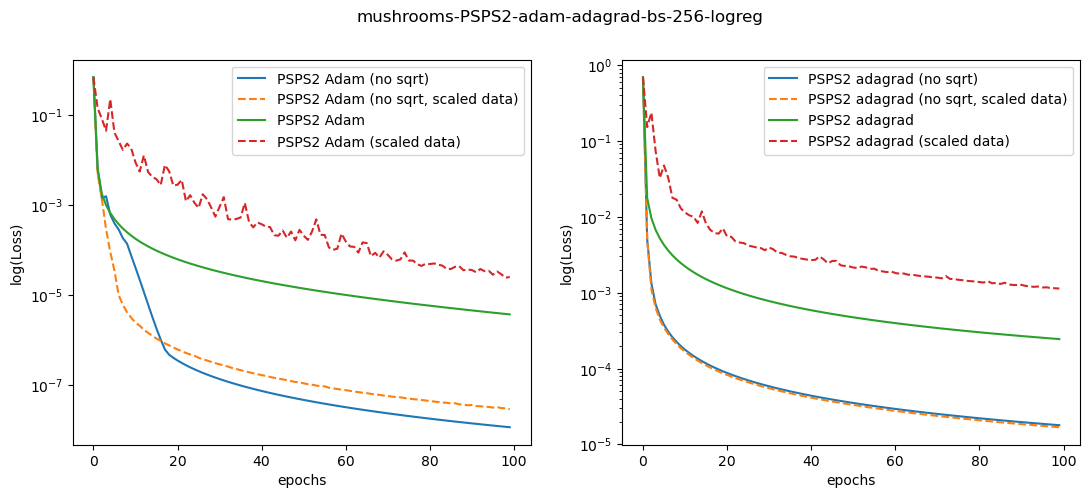

In [439]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# plt.semilogy([x[0] for x in hist_psps2_none], label=f"PSPS2 None")
# plt.semilogy([x[0] for x in hist_psps2_none_scaled], linestyle="--", label=f"PSPS2 None (scaled data)")

ax[0].semilogy([x[0] for x in hist_psps2_adam_m], label=f"PSPS2 Adam (no sqrt)")
ax[0].semilogy([x[0] for x in hist_psps2_adam_m_scaled], linestyle="--", label=f"PSPS2 Adam (no sqrt, scaled data)")
ax[0].semilogy([x[0] for x in hist_psps2_adam], label=f"PSPS2 Adam")
ax[0].semilogy([x[0] for x in hist_psps2_adam_scaled], linestyle="--", label=f"PSPS2 Adam (scaled data)")


# plt.semilogy([x[0] for x in hist_custom_sp2plus], label=f"SP2+")
# plt.semilogy([x[0] for x in hist_custom_sp2plus_scaled], linestyle="--", label=f"SP2+ (scaled data))")


ax[1].semilogy([x[0] for x in hist_psps2_adagrad_m], label=f"PSPS2 adagrad (no sqrt)")
ax[1].semilogy([x[0] for x in hist_psps2_adagrad_m_scaled], linestyle="--", label=f"PSPS2 adagrad (no sqrt, scaled data)")
ax[1].semilogy([x[0] for x in hist_psps2_adagrad], label=f"PSPS2 adagrad")
ax[1].semilogy([x[0] for x in hist_psps2_adagrad_scaled], linestyle="--", label=f"PSPS2 adagrad (scaled data)")


ax[0].set_ylabel("log(Loss)")
ax[0].set_xlabel("epochs")

ax[1].set_ylabel("log(Loss)")
ax[1].set_xlabel("epochs")

ax[0].legend()
ax[1].legend()


title = f"{dataset_name}-PSPS2-adam-adagrad-bs-{batch_size}-{loss_function.__name__}"
fig.suptitle(title)

# plt.savefig(f"experiments/plots/{title}.jpeg", format="jpeg")

In [380]:
def adam(train_data, train_target, train_dataloader, lr, step_type="sqrt"):
    
    torch.manual_seed(0)
    w = torch.zeros(train_data.shape[1]).requires_grad_()

    hist = []
    step_norms = []

    loss = loss_function(w, train_data, train_target)
    g, = torch.autograd.grad(loss, w, create_graph=True)

    betas = (0.9, 0.999)
    m = torch.zeros_like(g)
    v = torch.zeros_like(g)
    step_t = torch.tensor(0.)

    for epoch in range(EPOCHS):

        loss = loss_function(w, train_data, train_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)
        hist.append([loss.item(), torch.sum(torch.square(g)).item()])


        for batch_data, batch_target in train_dataloader:

            loss = loss_function(w, batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.detach().clone()

            step_t += 1

            m = betas[0] * m + (1 - betas[0]) * f_grad
            v = betas[1] * v + (1 - betas[1]) * f_grad.square()
            m_hat = m / (1 - torch.pow(betas[0], step_t))
            v_hat = v / (1 - torch.pow(betas[1], step_t))


            if step_type == "sqrt":
                step = torch.sqrt(v_hat) + 1e-8
            else:
                step = v_hat + 1e-8
            
            with torch.no_grad():
                w.sub_(m_hat / step, alpha=lr)

            step_norms.append(lr / torch.norm(step).item())
        
    return hist, step_norms

In [657]:
hist_psps2_cg = run_psps2(train_data, train_target, train_dataloader, epochs=50, precond_method="cg")

[0/50] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0


[1/50] | Loss: 0.02947141837086581 | GradNorm^2: 0.0001726096528277809 | Accuracy: 0.9929837518463811
[2/50] | Loss: 0.009270036233862189 | GradNorm^2: 1.4579480186017912e-05 | Accuracy: 0.9983998030526834
[3/50] | Loss: 0.006733462649664607 | GradNorm^2: 2.3142588536256106e-05 | Accuracy: 0.999015263417036
[4/50] | Loss: 0.0032934097781456644 | GradNorm^2: 1.498256720983469e-05 | Accuracy: 0.999015263417036
[5/50] | Loss: 0.0022598927678802263 | GradNorm^2: 1.0042119240363236e-05 | Accuracy: 0.9992614475627769
[6/50] | Loss: 0.0019930647336005923 | GradNorm^2: 8.043012919474256e-06 | Accuracy: 0.9992614475627769
[7/50] | Loss: 0.0012430892876886133 | GradNorm^2: 4.280651150855967e-06 | Accuracy: 0.999507631708518
[8/50] | Loss: 0.001185509353419221 | GradNorm^2: 3.679905343089985e-06 | Accuracy: 0.999507631708518
[9/50] | Loss: 0.001153152853531982 | GradNorm^2: 3.363393560021003e-06 | Accuracy: 0.999507631708518
[10/50] | Loss: 0.0007155718391361949 | GradNorm^2: 1.8313216321421578e-

In [658]:
hist_psps2_none  = run_psps2(train_data, train_target, train_dataloader, epochs=50, precond_method="none")

[0/50] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/50] | Loss: 0.004062268587040435 | GradNorm^2: 1.8358218703274006e-05 | Accuracy: 0.999015263417036
[2/50] | Loss: 0.0020230043261979646 | GradNorm^2: 1.2430064298038791e-05 | Accuracy: 0.999015263417036
[3/50] | Loss: 0.0008656142008840718 | GradNorm^2: 1.7357152657805885e-06 | Accuracy: 0.9997538158542589
[4/50] | Loss: 0.0004898109793345844 | GradNorm^2: 1.7851592895672052e-07 | Accuracy: 1.0
[5/50] | Loss: 0.0003636656739132717 | GradNorm^2: 5.296051868873461e-08 | Accuracy: 1.0
[6/50] | Loss: 0.00029385804109981076 | GradNorm^2: 2.6400687305049892e-08 | Accuracy: 1.0
[7/50] | Loss: 0.00024675776253910907 | GradNorm^2: 1.549831299584062e-08 | Accuracy: 1.0
[8/50] | Loss: 0.0002132780061605895 | GradNorm^2: 1.0669794694960524e-08 | Accuracy: 1.0
[9/50] | Loss: 0.00018828899379795663 | GradNorm^2: 8.20923311270481e-09 | Accuracy: 1.0
[10/50] | Loss: 0.00016871641007201366 | GradNorm^2: 6.6083167923

In [659]:
hist_psps2_adam  = run_psps2(train_data, train_target, train_dataloader, epochs=50, precond_method="adam")

[0/50] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/50] | Loss: 0.0007302889234672146 | GradNorm^2: 1.0509224084500175e-06 | Accuracy: 1.0
[2/50] | Loss: 6.140982807280982e-05 | GradNorm^2: 2.5696552675605792e-08 | Accuracy: 1.0
[3/50] | Loss: 1.4019208850634482e-05 | GradNorm^2: 2.744860200673783e-09 | Accuracy: 1.0
[4/50] | Loss: 2.538039550574267e-06 | GradNorm^2: 8.892701301253711e-11 | Accuracy: 1.0
[5/50] | Loss: 8.181674631450465e-07 | GradNorm^2: 9.629137947610766e-12 | Accuracy: 1.0
[6/50] | Loss: 2.1719721227075338e-07 | GradNorm^2: 6.431835480099015e-13 | Accuracy: 1.0
[7/50] | Loss: 7.594800089197397e-08 | GradNorm^2: 7.717946026680187e-14 | Accuracy: 1.0
[8/50] | Loss: 3.664388203957552e-08 | GradNorm^2: 1.867493358171608e-14 | Accuracy: 1.0
[9/50] | Loss: 1.7628592066597903e-08 | GradNorm^2: 4.38058282181362e-15 | Accuracy: 1.0
[10/50] | Loss: 1.0444852294558594e-08 | GradNorm^2: 1.6130796897021847e-15 | Accuracy: 1.0
[11/50] | Loss: 6.2

In [660]:
hist_psps2_adagrad  = run_psps2(train_data, train_target, train_dataloader, epochs=50, precond_method="adagrad")

[0/50] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0


[1/50] | Loss: 0.0025977095749530406 | GradNorm^2: 1.3982081558122343e-06 | Accuracy: 1.0
[2/50] | Loss: 0.0013698800704394533 | GradNorm^2: 2.2753401389168265e-07 | Accuracy: 1.0
[3/50] | Loss: 0.0009440031779298249 | GradNorm^2: 1.079319678089681e-07 | Accuracy: 1.0
[4/50] | Loss: 0.0007241021133748009 | GradNorm^2: 6.835990794923482e-08 | Accuracy: 1.0
[5/50] | Loss: 0.0005889781996316301 | GradNorm^2: 4.862778730485116e-08 | Accuracy: 1.0
[6/50] | Loss: 0.0004971965236862162 | GradNorm^2: 3.667782105424546e-08 | Accuracy: 1.0
[7/50] | Loss: 0.00043063462299757697 | GradNorm^2: 2.8678776999604846e-08 | Accuracy: 1.0
[8/50] | Loss: 0.00038007506537900956 | GradNorm^2: 2.298658406413262e-08 | Accuracy: 1.0
[9/50] | Loss: 0.0003403219587111808 | GradNorm^2: 1.876207542146269e-08 | Accuracy: 1.0
[10/50] | Loss: 0.0003082186665865134 | GradNorm^2: 1.5530518779961478e-08 | Accuracy: 1.0
[11/50] | Loss: 0.0002817345397687964 | GradNorm^2: 1.3002888230205838e-08 | Accuracy: 1.0
[12/50] | Lo

In [661]:
hist_psps2_hutch  = run_psps2(train_data, train_target, train_dataloader, epochs=50, precond_method="hutch")

[0/50] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/50] | Loss: 0.004845649916174554 | GradNorm^2: 1.3400157464698192e-05 | Accuracy: 0.999015263417036
[2/50] | Loss: 0.0018309871852036207 | GradNorm^2: 1.2630829041007102e-05 | Accuracy: 0.999015263417036
[3/50] | Loss: 0.0012073893984236178 | GradNorm^2: 8.203275207384909e-06 | Accuracy: 0.9992614475627769
[4/50] | Loss: 0.0004996968684750535 | GradNorm^2: 2.2251908926548156e-06 | Accuracy: 0.9997538158542589
[5/50] | Loss: 0.00019517125700575864 | GradNorm^2: 3.8728674205442114e-07 | Accuracy: 1.0
[6/50] | Loss: 9.004304427493976e-05 | GradNorm^2: 6.460701431257827e-08 | Accuracy: 1.0
[7/50] | Loss: 4.6925821466931366e-05 | GradNorm^2: 8.362278010781937e-09 | Accuracy: 1.0
[8/50] | Loss: 3.4233472787969035e-05 | GradNorm^2: 2.7083959813106836e-09 | Accuracy: 1.0
[9/50] | Loss: 2.767779214210754e-05 | GradNorm^2: 1.2710631333443421e-09 | Accuracy: 1.0
[10/50] | Loss: 2.3243247559485902e-05 | GradNorm

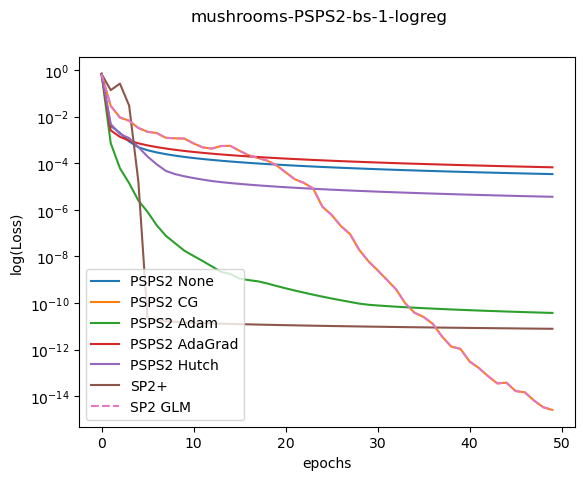

In [665]:
plt.semilogy([x[0] for x in hist_psps2_none], label="PSPS2 None")
plt.semilogy([x[0] for x in hist_psps2_cg], label="PSPS2 CG")
plt.semilogy([x[0] for x in hist_psps2_adam], label="PSPS2 Adam")
plt.semilogy([x[0] for x in hist_psps2_adagrad], label="PSPS2 AdaGrad")
plt.semilogy([x[0] for x in hist_psps2_hutch], label="PSPS2 Hutch")
plt.semilogy([x[0] for x in hist_custom_sp2plus], label="SP2+")
plt.semilogy([x[0] for x in hist_sp2glm], linestyle="--", label="SP2 GLM")


plt.ylabel("log(Loss)")
plt.xlabel("epochs")

plt.legend()


title = f"{dataset_name}-PSPS2-bs-{batch_size}-{loss_function.__name__}"
plt.suptitle(title)

plt.savefig(f"experiments/plots/{title}.pdf", format="pdf")